In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller 
from sklearn.preprocessing import MinMaxScaler 
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM 

import os
import sys
import warnings
import random

In [2]:
#notebook reproducible 
np.random.seed(42)
random.seed(42)

In [3]:
sys.path.append(os.path.abspath(os.path.join('../scripts')))

Data Ingestion and Load

In [4]:
df = pd.read_csv('../data/train_cleaned.csv', parse_dates=['Date'])
df.drop(['Unnamed: 0'], axis=1, inplace=True)
print(f"The dataset contains {len(df)} Sales Data")
pd.set_option('display.max_columns', len(df.columns)) # To view all columns , , index_col='Date'
pd.set_option('display.max_rows', 100)
df.head(3)

C:\Users\Machine\AppData\Local\Temp\ipykernel_59904\145361647.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/train_cleaned.csv', parse_dates=['Date'])


The dataset contains 1017209 Sales Data


,Date,Store,DayOfWeek,Sales,Open,Promo,StateHoliday,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,Year,Month,Day,weekday,weekofyear,weekend,PromoInterval,Assortment,StoreType
0,2015-07-31,1,4,5263.0,1,1,0,1,1270.0,9.0,2008.0,0,22.0,2012.0,2015,7,31,4,31,0,1,0,2
1,2015-07-31,2,4,6064.0,1,1,0,1,570.0,11.0,2007.0,1,13.0,2010.0,2015,7,31,4,31,0,1,0,0
2,2015-07-31,3,4,8314.0,1,1,0,1,14130.0,12.0,2006.0,1,14.0,2011.0,2015,7,31,4,31,0,1,0,0


Isolate the Rossmann Store Sales Dataset into Time Series Data

In [5]:
data = df.groupby("Date").agg({"Sales": "mean"})
data.head(10)

,Sales
Date,
2013-01-01,84.396320
2013-01-02,6178.525112
2013-01-03,5660.178027
2013-01-04,5923.143498
2013-01-05,5299.056502
2013-01-06,119.358744
2013-01-07,9378.052018
2013-01-08,7742.754709
2013-01-09,6887.266368


Check if the Time Series Data is Stationary
Correlation between date and sales

In [6]:
adfResult = adfuller(data.Sales.values, autolag='AIC')
print(f'ADF Statistic: {adfResult[0]}')
print(f'p-value: {adfResult[1]}')

ADF Statistic: -5.751267839815723
p-value: 5.958868619620615e-07


In [7]:
scaler = MinMaxScaler()

try:
    scaler.fit(data.Sales.values.reshape([-1, 1]))
    scaled_array = scaler.transform(data.Sales.values.reshape(-1, 1))
    data['SalesScaled'] = scaled_array
    data.tail(10)

    print("Data scaled successfully.")

except Exception as e:
    print(f"Scaling error, {e}")

Data scaled successfully.


Differencing the Time Series

In [8]:
# Create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

salesScaledDiff = difference(data.SalesScaled.values)
salesScaledDiff

0      0.506967
1     -0.043121
2      0.021876
3     -0.051917
4     -0.430896
         ...   
936    0.760620
937   -0.108573
938   -0.043412
939    0.022197
940    0.089604
Length: 941, dtype: float64

Making the Data ready for Modeling

In [9]:
SIZE = len(data.SalesScaled)
WINDOW_SIZE = 48
BATCH_SIZE = SIZE - WINDOW_SIZE * 2
EPOCHS = 200

In [10]:
DateTrain = data.index.values[0:BATCH_SIZE]
DateValid = data.index.values[BATCH_SIZE:]
XTrain = data.SalesScaled.values[0:BATCH_SIZE].astype('float32')
XValid = data.SalesScaled.values[BATCH_SIZE:].astype('float32')

# Obtain shapes for vectors of size (,1) for dates series

DateTrain = np.reshape(DateTrain, (-1, 1))
DateValid = np.reshape(DateValid, (-1, 1))

print("Shape of the training set date series: ", DateTrain.shape)
print("Shape of the validation set date series: ", DateValid.shape)
print()
print("Shape of the training set logarithm of sales series: ", XTrain.shape)
print("Shape of the validation set logarithm of sales series in a stateless LSTM: ", XValid.shape)

Shape of the training set date series:  (846, 1)
Shape of the validation set date series:  (96, 1)

Shape of the training set logarithm of sales series:  (846,)
Shape of the validation set logarithm of sales series in a stateless LSTM:  (96,)


In [11]:
tf.random.set_seed(1234)
# add extra dimension
series = tf.expand_dims(XTrain, axis=-1)
series.shape

TensorShape([846, 1])

In [12]:
# create tensor from each individual element
dataset = tf.data.Dataset.from_tensor_slices(series)
dataset

<TensorSliceDataset element_spec=TensorSpec(shape=(1,), dtype=tf.float32, name=None)>

In [13]:
# takes a window_size + 1 chunk from the slices
dataset = dataset.window(WINDOW_SIZE + 1, shift=1, drop_remainder=True)

In [14]:
datasetEx = tf.data.Dataset.from_tensor_slices(tf.range(10))
datasetEx = datasetEx.window(5, shift=1, drop_remainder=True)
for window in datasetEx:
    print([elem.numpy() for elem in window])

[0, 1, 2, 3, 4]
[1, 2, 3, 4, 5]
[2, 3, 4, 5, 6]
[3, 4, 5, 6, 7]
[4, 5, 6, 7, 8]
[5, 6, 7, 8, 9]


In [15]:
def windowed_dataset(series, window_size=WINDOW_SIZE, batch_size=BATCH_SIZE):
  series = tf.expand_dims(series, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [16]:
DatasetTrain = windowed_dataset(XTrain)
DatasetVal = windowed_dataset(XValid)

In [52]:
train_size = int(len(data) * 0.70)
test_size = len(data) - train_size
train, test = data.iloc[0:train_size], data.iloc[train_size:len(data)]
print(train.shape, test.shape)

(659, 2) (283, 2)


Model Building

In [17]:
model = Sequential()
model.add(LSTM(8, input_shape=[None, 1], return_sequences=True))
model.add(LSTM(4, input_shape=[None, 1]))
model.add(Dense(1))
model.compile(loss="huber_loss", optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 8)           320       
                                                                 
 lstm_1 (LSTM)               (None, 4)                 208       
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 533
Trainable params: 533
Non-trainable params: 0
_________________________________________________________________


Training the Model

In [18]:
history = model.fit(DatasetTrain, epochs=EPOCHS, validation_data=DatasetVal, verbose=1)

Epoch 1/200
1/1 [==============================] - 10s 10s/step - loss: 0.0568 - val_loss: 0.0558
Epoch 2/200
1/1 [==============================] - 0s 284ms/step - loss: 0.0520 - val_loss: 0.0510
Epoch 3/200
1/1 [==============================] - 0s 264ms/step - loss: 0.0476 - val_loss: 0.0466
Epoch 4/200
1/1 [==============================] - 0s 232ms/step - loss: 0.0437 - val_loss: 0.0426
Epoch 5/200
1/1 [==============================] - 0s 257ms/step - loss: 0.0403 - val_loss: 0.0392
Epoch 6/200
1/1 [==============================] - 0s 429ms/step - loss: 0.0373 - val_loss: 0.0363
Epoch 7/200
1/1 [==============================] - 0s 231ms/step - loss: 0.0348 - val_loss: 0.0338
Epoch 8/200
1/1 [==============================] - 0s 278ms/step - loss: 0.0328 - val_loss: 0.0317
Epoch 9/200
1/1 [==============================] - 0s 396ms/step - loss: 0.0311 - val_loss: 0.0301
Epoch 10/200
1/1 [==============================] - 0s 226ms/step - loss: 0.0299 - val_loss: 0.0288
Epoch 11/2

1/1 [==============================] - 0s 274ms/step - loss: 0.0277 - val_loss: 0.0267
Epoch 84/200
1/1 [==============================] - 0s 270ms/step - loss: 0.0277 - val_loss: 0.0267
Epoch 85/200
1/1 [==============================] - 0s 260ms/step - loss: 0.0277 - val_loss: 0.0267
Epoch 86/200
1/1 [==============================] - 0s 209ms/step - loss: 0.0277 - val_loss: 0.0266
Epoch 87/200
1/1 [==============================] - 0s 427ms/step - loss: 0.0277 - val_loss: 0.0266
Epoch 88/200
1/1 [==============================] - 0s 288ms/step - loss: 0.0277 - val_loss: 0.0266
Epoch 89/200
1/1 [==============================] - 0s 202ms/step - loss: 0.0277 - val_loss: 0.0266
Epoch 90/200
1/1 [==============================] - 0s 335ms/step - loss: 0.0277 - val_loss: 0.0266
Epoch 91/200
1/1 [==============================] - 0s 262ms/step - loss: 0.0277 - val_loss: 0.0266
Epoch 92/200
1/1 [==============================] - 0s 244ms/step - loss: 0.0277 - val_loss: 0.0265
Epoch 93/200


1/1 [==============================] - 0s 260ms/step - loss: 0.0272 - val_loss: 0.0259
Epoch 165/200
1/1 [==============================] - 0s 273ms/step - loss: 0.0271 - val_loss: 0.0259
Epoch 166/200
1/1 [==============================] - 0s 270ms/step - loss: 0.0271 - val_loss: 0.0259
Epoch 167/200
1/1 [==============================] - 0s 222ms/step - loss: 0.0271 - val_loss: 0.0259
Epoch 168/200
1/1 [==============================] - 0s 310ms/step - loss: 0.0271 - val_loss: 0.0259
Epoch 169/200
1/1 [==============================] - 0s 254ms/step - loss: 0.0271 - val_loss: 0.0259
Epoch 170/200
1/1 [==============================] - 0s 264ms/step - loss: 0.0271 - val_loss: 0.0258
Epoch 171/200
1/1 [==============================] - 0s 215ms/step - loss: 0.0271 - val_loss: 0.0258
Epoch 172/200
1/1 [==============================] - 0s 277ms/step - loss: 0.0271 - val_loss: 0.0258
Epoch 173/200
1/1 [==============================] - 0s 276ms/step - loss: 0.0271 - val_loss: 0.0258
Epoc

In [19]:
loss = model.evaluate(DatasetVal, verbose=1)
t_loss = model.evaluate(DatasetTrain, verbose=1)

1/1 [==============================] - 0s 232ms/step - loss: 0.0269


In [20]:
print("Training loss = %f" % (t_loss))
print("Validation loss = %f" % (loss))

Training loss = 0.026879
Validation loss = 0.025474


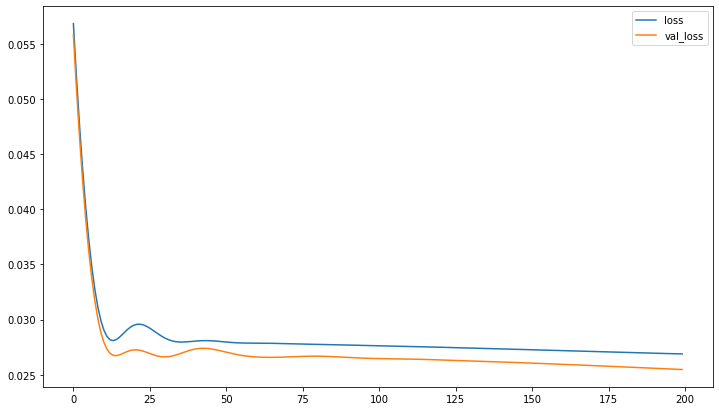

In [21]:
fig = plt.figure(figsize=(12, 7))
plt.plot(history.history['loss'], label="loss")
plt.plot(history.history['val_loss'], label="val_loss")
plt.legend()
plt.show()

In [22]:
from time import gmtime, strftime

time = strftime("%Y-%m-%d", gmtime())

In [23]:
model.save(f'../model/LSTM_sales_pred_model {time}.pkl')

INFO:tensorflow:Assets written to: ../model/LSTM_sales_pred_model 2022-09-09.pkl\assets


INFO:tensorflow:Assets written to: ../model/LSTM_sales_pred_model 2022-09-09.pkl\assets


Model Prediction

In [66]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True) 
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(SIZE).prefetch(1)
    forecast = model.predict(ds)
    return forecast

Forecast = model_forecast(model, data.SalesScaled.values[:, np.newaxis], WINDOW_SIZE)
Results = Forecast[BATCH_SIZE-WINDOW_SIZE:-1]
Results1 = scaler.inverse_transform(Results.reshape(-1,1))
XValid1 = scaler.inverse_transform(XValid.reshape(-1,1))

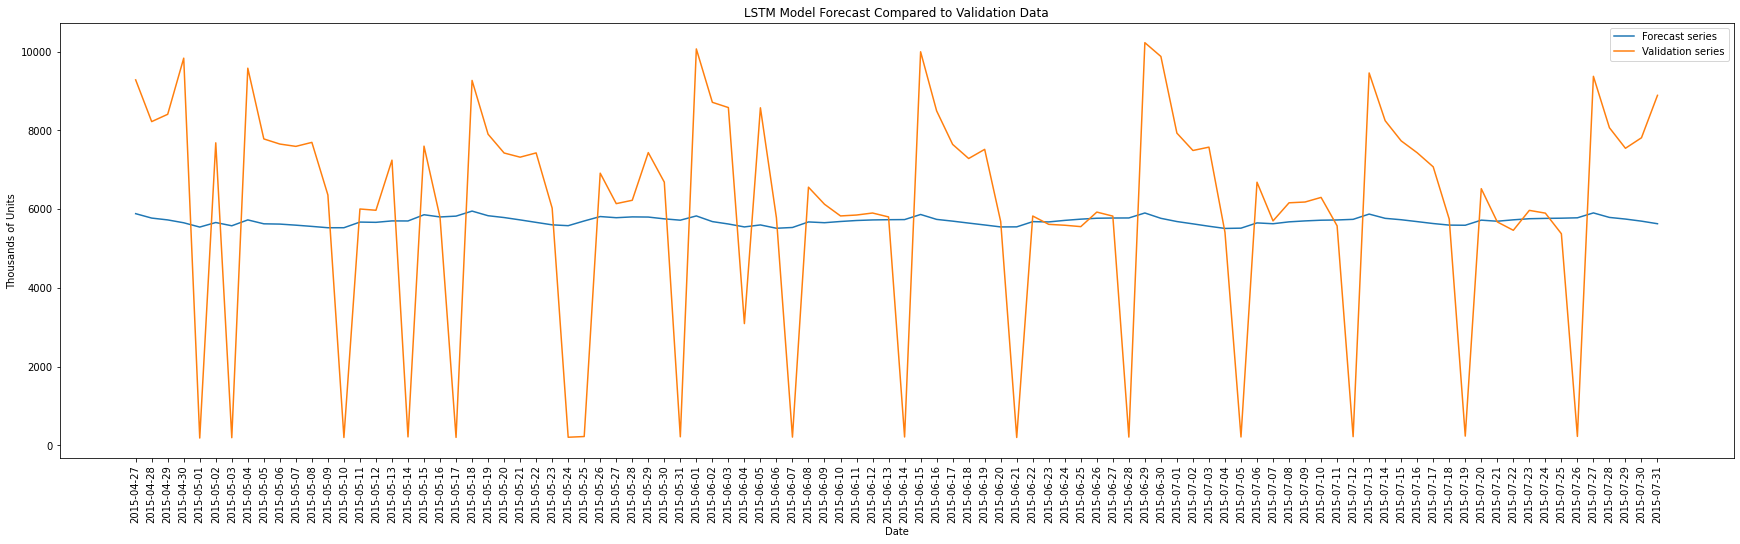

In [67]:
plt.figure(figsize=(30, 8))
plt.title("LSTM Model Forecast Compared to Validation Data")
plt.plot(DateValid.astype('datetime64'), Results1, label='Forecast series')
plt.plot(DateValid.astype('datetime64'), np.reshape(XValid1, (2*WINDOW_SIZE, 1)), label='Validation series')
plt.xlabel('Date')
plt.ylabel('Thousands of Units')
plt.xticks(DateValid.astype('datetime64')[:,-1], rotation = 90) 
plt.legend(loc="upper right")